## **LightGBM (Time series Regression)**

In [1]:
#import library
import numpy as np
import pandas as pd
import lightgbm as lgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.width', None)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
!git clone https://github.com/yun-seon/DX-Training-LGES-0630.git

Cloning into 'DX-Training-LGES-0630'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 79 (delta 3), reused 0 (delta 0), pack-reused 68
Unpacking objects: 100% (79/79), done.


In [3]:
# Data import
train = pd.read_csv("/content/DX-Training-LGES-0630/Data/Data_LightGBM_train.csv", parse_dates=['date'])
test = pd.read_csv("/content/DX-Training-LGES-0630/Data/Data_LightGBM_test.csv", parse_dates=['date'])
df = pd.concat([train, test], sort=False)
df

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN
...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0
44996,2018-03-28,10,50,NaN,44996.0
44997,2018-03-29,10,50,NaN,44997.0
44998,2018-03-30,10,50,NaN,44998.0


In [4]:
# sales variable = target variable
# for checking the information of data
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(train)

##################### Shape #####################
(913000, 4)
##################### Types #####################
date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object
##################### Head #####################
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
##################### Tail #####################
             date  store  item  sales
912997 2017-12-29     10    50     74
912998 2017-12-30     10    50     62
912999 2017-12-31     10    50     82
##################### NA #####################
date     0
store    0
item     0
sales    0
dtype: int64
##################### Quantiles #####################
       0.00  0.05  0.50   0.95   0.99   1.00
store   1.0   1.0   5.5   10.0   10.0   10.0
item    1.0   3.0  25.5   48.0   50.0   50.0
sales   0.0  16.0  47.0  107.0  135.0  231.0


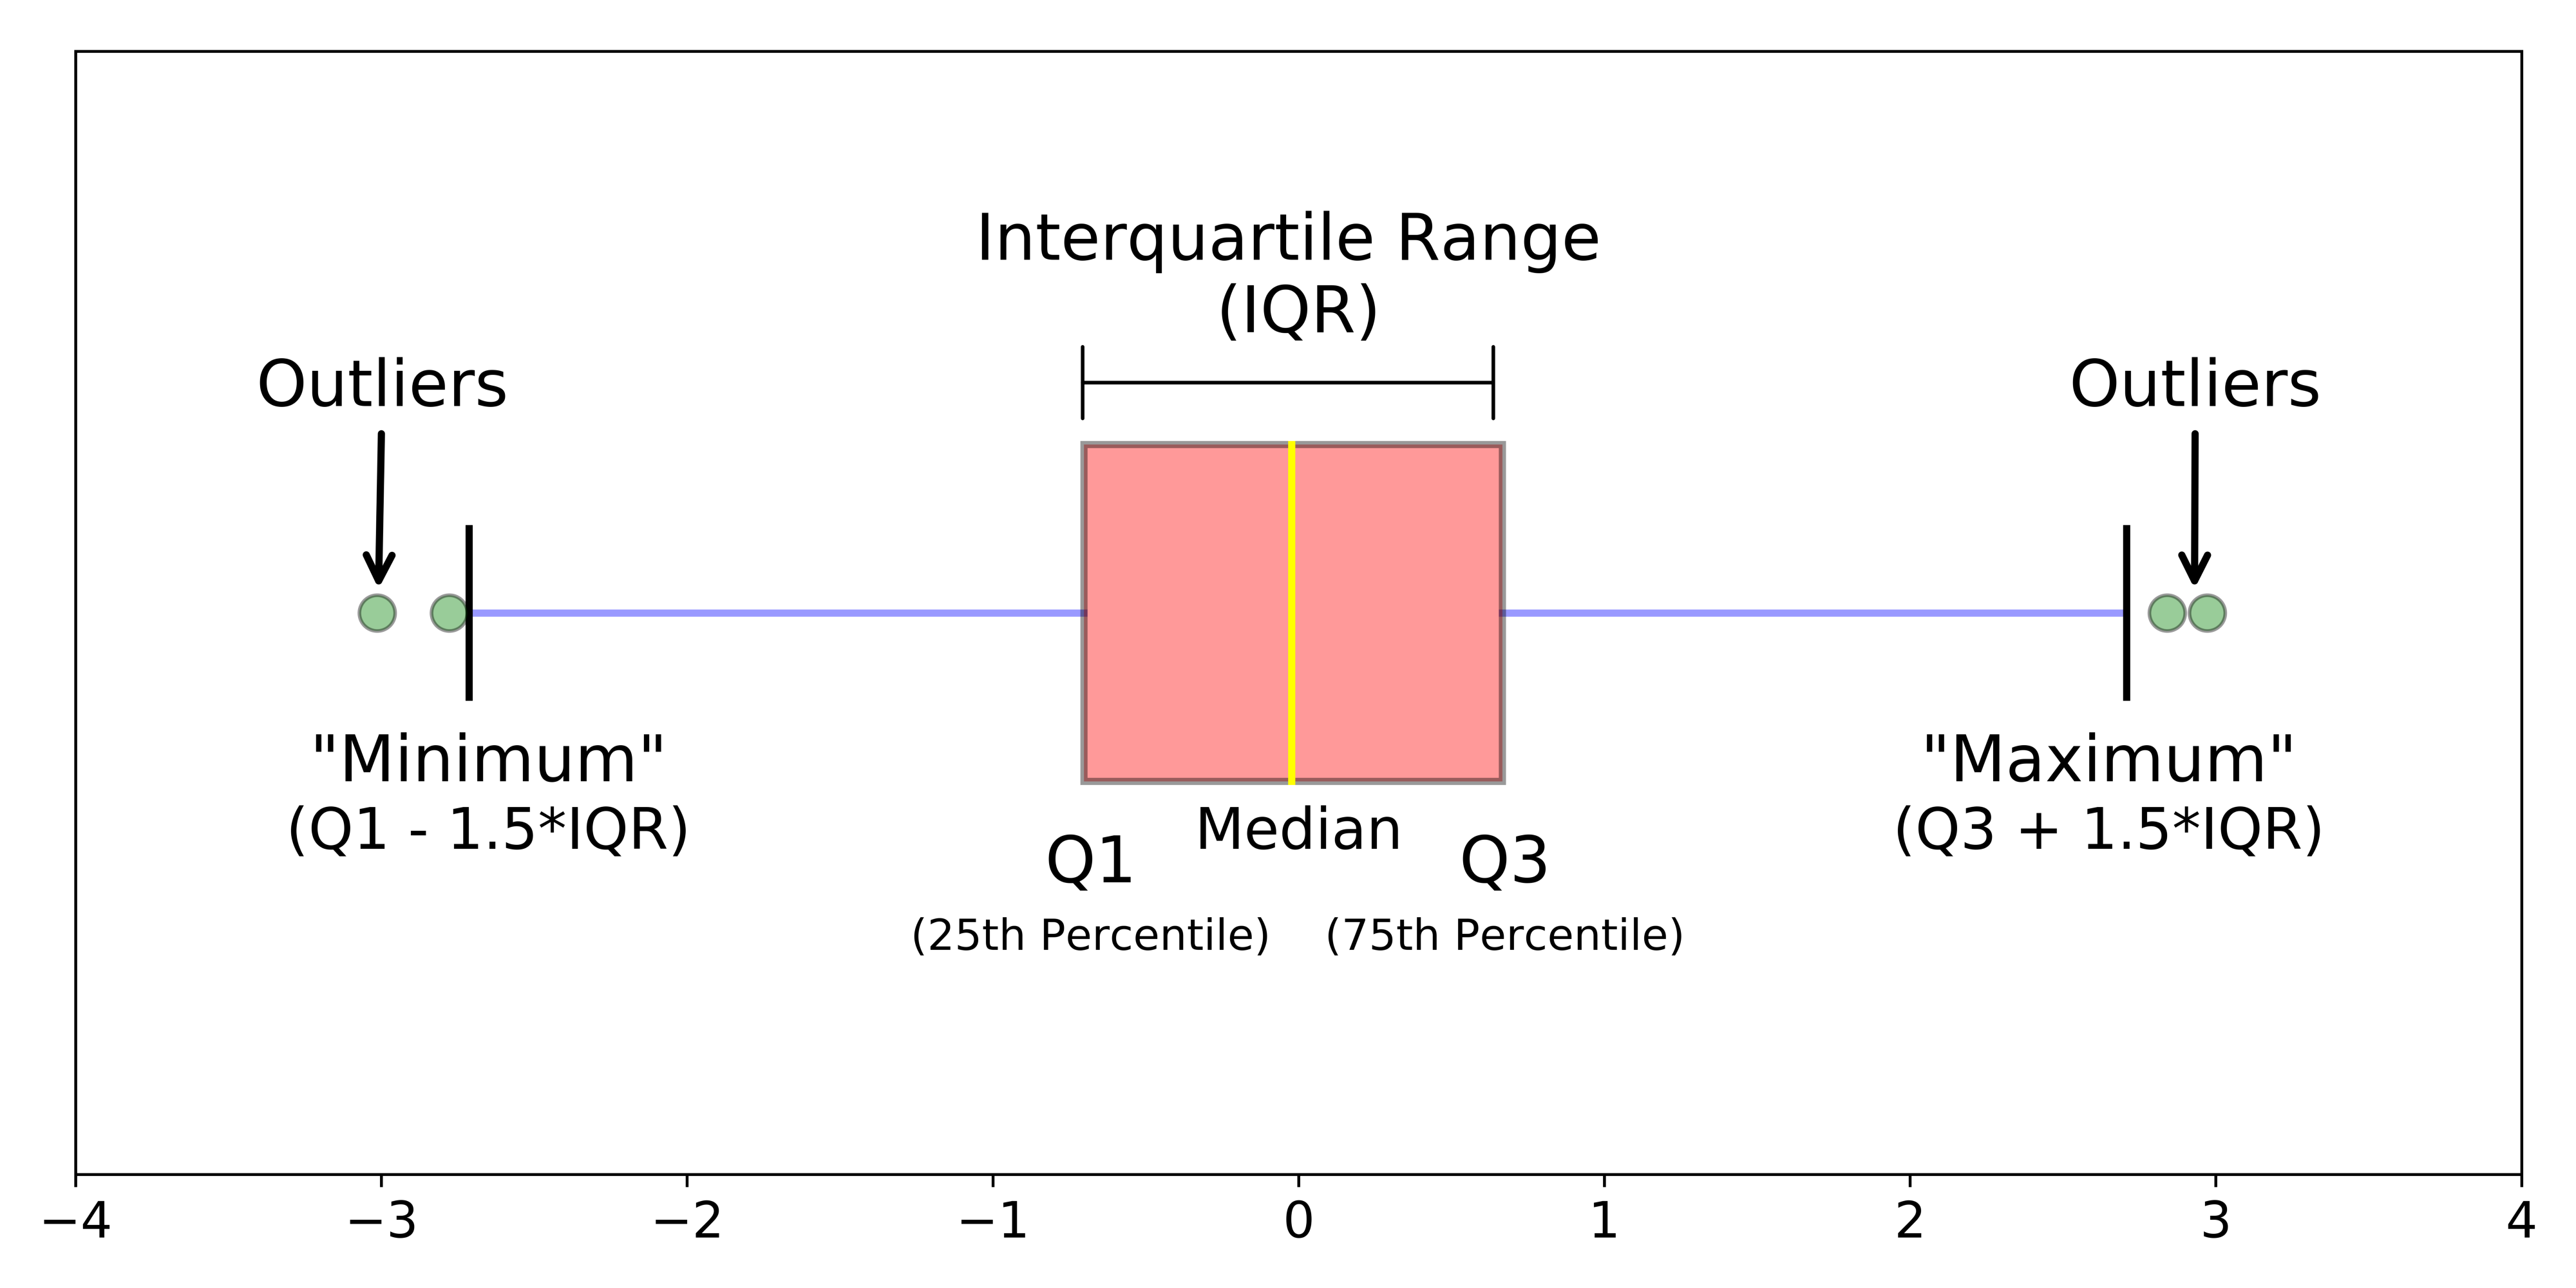

In [5]:
# IQR method 사용: Q1:0.05%, Q3:0.95%
# for outlier check
def outlier_thresholds(dataframe, col_name, q1_perc=0.05, q3_perc=0.95):
    """
    given dataframe, column name, q1_percentage and q3 percentage, function calculates low_limit and up_limit

    """
    quartile1 = dataframe[col_name].quantile(q1_perc)
    quartile3 = dataframe[col_name].quantile(q3_perc)
    interquantile_range = quartile3 - quartile1
    
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def check_outlier(dataframe, col_name, q1_perc=0.01, q3_perc=0.99):
    outlier_list = []
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1_perc=0.01, q3_perc=0.99)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True

    else:
        return False

check_outlier(df, 'sales')

False

In [6]:
print(f"total number of stores: {df['store'].nunique()}\n")
print(f"total number of items: {df['item'].nunique()}\n")
print(f"total number of items per each store: {df.groupby(['store'])['item'].nunique()}")

total number of stores: 10

total number of items: 50

total number of items per each store: store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64


In [7]:
# target 변수 sales의 sum, mean ,median, std 계산
df.groupby(["store", "item"]).agg({"sales": ["sum", "mean", "median", "std"]})

sales                             
                 sum       mean median        std
store item                                       
1     1      36468.0  19.971522   19.0   6.741022
      2      97050.0  53.148959   52.0  15.005779
      3      60638.0  33.208105   33.0  10.072529
      4      36440.0  19.956188   20.0   6.640618
      5      30335.0  16.612815   16.0   5.672102
...              ...        ...    ...        ...
10    46    120601.0  66.046550   65.0  18.114991
      47     45204.0  24.755750   24.0   7.924820
      48    105570.0  57.814896   57.0  15.898538
      49     60317.0  33.032311   32.0  10.091610
      50    135192.0  74.037240   73.0  19.937566

[500 rows x 4 columns]

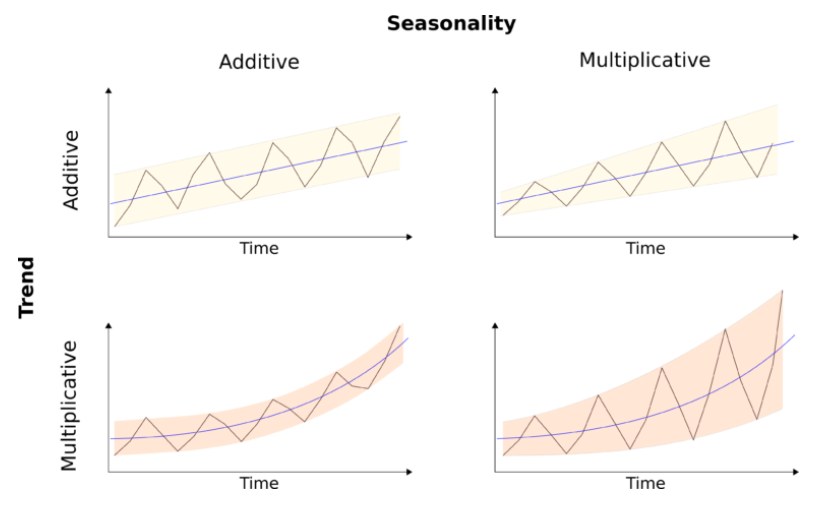

<Figure size 432x288 with 0 Axes>

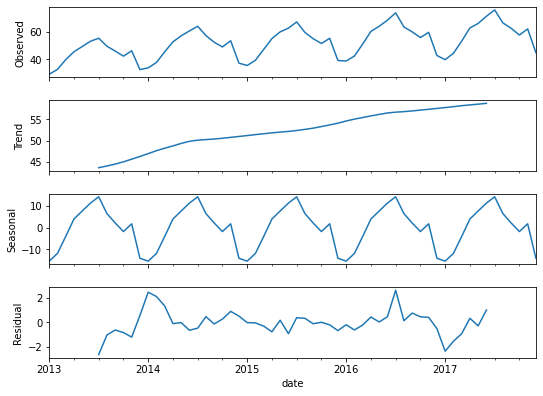

In [8]:
# time series decomposition
train_plot = train.set_index('date')
y = train_plot['sales'].resample('MS').mean() 

result = sm.tsa.seasonal_decompose(y, model='additive')
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(8, 6)

In [9]:
# feature engineering
# seanolity 찾기 위해서 date variable로 새로운 feature 형성
def create_date_features(df):
    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['week_of_year'] = df.date.dt.weekofyear
    # 1.1.2013 is Tuesday, so our starting point is the 2nd day of week
    df['day_of_week'] = df.date.dt.dayofweek + 1
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)
    return df

In [10]:
df = create_date_features(df)
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,2013,0,1,0
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,2013,0,0,0
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,2013,0,0,0
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,2013,1,0,0
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,2013,1,0,0


In [11]:
# Random noise
# overfitting 방지 위해 random noise(gaussian random noise) 추가
def random_noise(dataframe):

    return np.random.normal(size=(len(dataframe),))

In [12]:
# Lag & Shifted Features
# sort the values per store, item and date so that values would be shifted equally
df.sort_values(by = ['store', 'item', 'date'], axis=0, inplace = True) # inplace = true; 기존 dataframe을 수정

def lag_features(dataframe, lags):
    dataframe = dataframe.copy()
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91, 98, 105, 112, 119, 126, 182, 364, 546, 728])

In [13]:
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_91,sales_lag_98,sales_lag_105,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,2,...,41.098286,53.279111,67.279179,69.130013,67.897290,83.311877,77.719201,62.004197,96.388636,73.102861
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,3,...,63.633749,52.459193,67.008835,59.322963,76.831224,80.229328,79.573878,73.409464,80.434864,67.945885
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,4,...,59.504948,63.018059,72.054353,65.252195,73.346208,85.219774,82.358896,67.085854,100.939539,75.265027
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,5,...,74.494715,76.503288,71.259052,69.179190,68.746813,81.677945,89.272132,69.392166,78.316863,82.045776


In [14]:
# Rolling mean & Moving Average
def roll_mean_features(dataframe, windows):
    dataframe = dataframe.copy()
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df, [365, 546, 730])

In [15]:
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_lag_112,sales_lag_119,sales_lag_126,sales_lag_182,sales_lag_364,sales_lag_546,sales_lag_728,sales_roll_mean_365,sales_roll_mean_546,sales_roll_mean_730
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,2,...,69.130013,67.897290,83.311877,77.719201,62.004197,96.388636,73.102861,85.273175,87.986545,83.495524
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,3,...,59.322963,76.831224,80.229328,79.573878,73.409464,80.434864,67.945885,87.868998,85.203264,82.264383
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,4,...,65.252195,73.346208,85.219774,82.358896,67.085854,100.939539,75.265027,88.319465,86.683607,82.899151
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,5,...,69.179190,68.746813,81.677945,89.272132,69.392166,78.316863,82.045776,87.476739,84.916484,82.420615


In [16]:
# Exponentially weighted mean features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

In [17]:
df

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,...,sales_ewm_alpha_07_lag_728,sales_ewm_alpha_05_lag_91,sales_ewm_alpha_05_lag_98,sales_ewm_alpha_05_lag_105,sales_ewm_alpha_05_lag_112,sales_ewm_alpha_05_lag_180,sales_ewm_alpha_05_lag_270,sales_ewm_alpha_05_lag_365,sales_ewm_alpha_05_lag_546,sales_ewm_alpha_05_lag_728
0,2013-01-01,1,1,13.0,NaN,1,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,NaN,1,2,2,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,NaN,1,3,3,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,NaN,1,4,4,1,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,NaN,1,5,5,1,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,2018-03-27,10,50,NaN,44995.0,3,27,86,13,2,...,69.116907,51.309755,58.648702,64.033868,64.335072,80.828687,109.036310,71.734958,85.489012,68.933911
44996,2018-03-28,10,50,NaN,44996.0,3,28,87,13,3,...,68.335072,57.154878,54.824351,65.516934,62.167536,85.414343,114.018155,65.867479,82.744506,68.466956
44997,2018-03-29,10,50,NaN,44997.0,3,29,88,13,4,...,73.000522,58.077439,58.912176,68.758467,64.083768,94.207172,117.009078,69.433740,90.872253,71.733478
44998,2018-03-30,10,50,NaN,44998.0,3,30,89,13,5,...,80.000156,66.038719,66.956088,70.379233,65.541884,96.603586,108.004539,68.716870,84.936127,77.366739


In [18]:
# one-hot encoding을 통해 dummy 변수 생성
df = pd.get_dummies(df, columns=['store', 'item', 'day_of_week', 'month'])

df['sales'] = np.log1p(df["sales"].values)

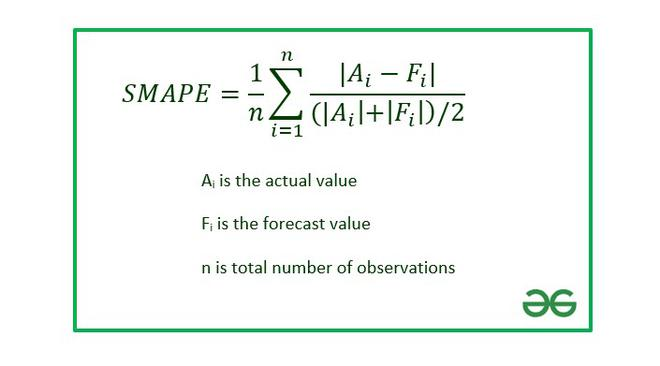

In [19]:
# SMAPE (Symmetric Mean Absolute Percentage Error) 평가지표 사용
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds-target)
    denom = np.abs(preds)+np.abs(target)
    smape_val = (200*np.sum(num/denom))/n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [20]:
# train 데이터에는 2013-2016에 해당하는 데이터가 포함됨
train = df.loc[(df["date"] < "2017-01-01"), :]
train["date"].min(), train["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2016-12-31 00:00:00'))

In [21]:
# val 데이터에는 2017년 1월 1일-2017년 4월 1일에 해당하는 데이터가 포함됨
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

In [22]:
# 불필요한 columns 삭제 
cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

In [23]:
# 최종 train, validation data
Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

In [24]:
#light gbm parameter
'''
Parameter 참고: https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html

boosting type:
    'gbdt' (traditional Gradient Boosting Decision Tree), 'dart' (Multiple Additive Regression Trees), 'goss' (Gradient-based One-side Sampling), 'rf' (Random Forest)
'''
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'boosting_type': 'goss', 
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 15000,
              'early_stopping_rounds': 200,
              'nthread': -1}

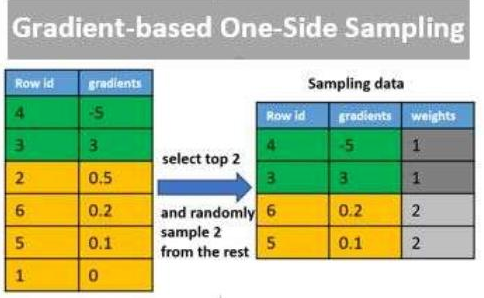

In [25]:
# dataset load
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [26]:
# model train
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  feval=lgbm_smape,
                  verbose_eval=200)

Training until validation scores don't improve for 200 rounds.
[200]	training's l1: 0.133333	training's SMAPE: 13.674	valid_1's l1: 0.138253	valid_1's SMAPE: 14.1968
[400]	training's l1: 0.129431	training's SMAPE: 13.284	valid_1's l1: 0.134003	valid_1's SMAPE: 13.7702
[600]	training's l1: 0.127966	training's SMAPE: 13.1378	valid_1's l1: 0.132771	valid_1's SMAPE: 13.6464
[800]	training's l1: 0.127153	training's SMAPE: 13.0565	valid_1's l1: 0.132026	valid_1's SMAPE: 13.5716
[1000]	training's l1: 0.126616	training's SMAPE: 13.0025	valid_1's l1: 0.131773	valid_1's SMAPE: 13.5464
[1200]	training's l1: 0.126244	training's SMAPE: 12.9652	valid_1's l1: 0.131679	valid_1's SMAPE: 13.537
[1400]	training's l1: 0.125943	training's SMAPE: 12.9348	valid_1's l1: 0.131583	valid_1's SMAPE: 13.5274
Early stopping, best iteration is:
[1391]	training's l1: 0.125955	training's SMAPE: 12.9361	valid_1's l1: 0.131538	valid_1's SMAPE: 13.5229


In [27]:
# validation data에 있는 sales 값이 예측되며 이는 log value로 계산됨
y_pred_val = model.predict(X_val)

In [28]:
# log value에 지수 취해준 후 smape 평가지표 계산
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.522883816487054

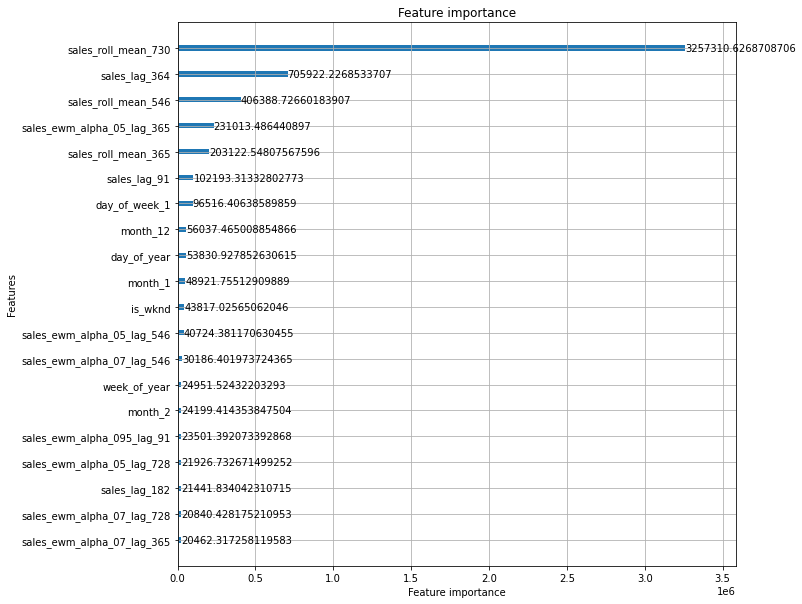

In [29]:
# 변수중요도 계산
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()

In [30]:
# train과 validation data가 concatenate된 후 train, test data(sales(타겟변수) NAN으로 표시됨) 생성
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]
test = df.loc[df.sales.isna()]
X_test = test[cols]

In [31]:
# model train시 도출된 best iteration 값 대입 (다양한 case에 대해 적용 후)
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

In [32]:
# 최적의 파라미터로 model train 후 test data prediction 도출
lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

In [33]:
# 최종 결과: 2018년 1월 1일 부터 2018년 3월 31일까지의 sales를 의미함
submission_df = test.loc[:, ['id', 'sales']]
submission_df['sales'] = np.expm1(test_preds)
submission_df['id'] = submission_df.id.astype(int)

submission_df.head()

,id,sales
0,0,12.282086
1,1,14.611504
2,2,13.999098
3,3,15.625318
4,4,17.454221
